# Ridge Regression (interpretation)

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of Ridge Regression from sklearn to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use the implementation above to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

We will continue to use the House data from previous notebooks.  (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)

## Libraries, same old dance

In [1]:
import sklearn, pandas
import numpy as np

## Polynomial regression, revisited

We call back on the material from the previous Lab (*lab-3.ipynb*), where we wrote the function to produce an DataFrame with columns containing the powers of a given input. Copy and paste the function `polynomial_dataframe` from there:

In [2]:
def polynomial_dataframe(feature, degree):
    # assume that degree >= 1
    # initialize the DataFrame:
    poly_data = pandas.DataFrame()
    # and set poly_data['power_1'] equal to the passed feature
    poly_data['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_data['power_' + str(power)] = poly_data['power_1'].apply(lambda x: x**power)
    return poly_data

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
full_data = pandas.read_csv("kc_house_data.csv", index_col=0)

As in the previous lab, we will use the 'sqft_living' variable. For plotting purposes (connecting the dots), you'll need to sort by the values of 'sqft_living'. For houses with identical square footage, we break the tie by their prices.

In [5]:
full_data = full_data.sort_values(['sqft_living', 'price'])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_dataframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [6]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights. You can consult [sklearn's Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

Also, it is in our best interest to normalize the values to Gaussian distribution via [sklearn's StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), as we know penalty values regulate the magnitude of weights, which is inversely propotional to the polynomial (and thus very large) values.

In [7]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
# Handholding level: Moderate
poly_data = polynomial_dataframe(full_data['sqft_living'], 15)
scaler = StandardScaler().fit(poly_data)
poly_features = scaler.transform(poly_data.values)
# continues by yourself.
y_output = full_data['price']
model = Ridge(alpha=l2_small_penalty).fit(poly_features, y_output)
model.coef_

array([    94003.5118202 ,    732508.73360614,  -4692242.512003  ,
        17570698.00681859, -30358561.93385957,   8483630.35691537,
        28562702.20640779,  -4058960.01709945, -25872396.64712825,
       -10751253.15308532,  14362763.04822449,  18381334.42697965,
        -1340560.43586855, -18342231.53521781,   7427620.16637745])

***QUIZ QUESTION:  What's the learned value for the coefficient of feature `power_1`?***

# Observe overfitting

Recall from the last lab that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. We will see in a moment that ridge regression reduces such variance. But first, we must reproduce the experiment we did.

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `train_test_split` function and make sure you set `random_state=0`. 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
big_set_1, big_set_2 = train_test_split(full_data, train_size=0.5, test_size=0.5, random_state=0)
set_1, set_2 = train_test_split(big_set_1, train_size=0.5, test_size=0.5, random_state=0)
set_3, set_4 = train_test_split(big_set_2, train_size=0.5, test_size=0.5, random_state=0)

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# return model and data features for training and target
def get_models_and_data(sets_data: list, feature_name: str, target: str, power: int, ridge_l2_penalty=None):
    models_and_data = []
    for i in range(len(sets_data)):
        sets_data[i] = sets_data[i].sort_values(['sqft_living', 'price'])
        poly_data = polynomial_dataframe(sets_data[i][feature_name], power) # create polynomial up to #power degree
        y_output = sets_data[i][target]
        model = None
        if ridge_l2_penalty == None:
            model = LinearRegression().fit(poly_data.values, y_output)
        else:
            X_features = scaler.transform(poly_data.values) 
            model = Ridge(alpha=ridge_l2_penalty).fit(X_features, y_output)
        models_and_data.append([model, poly_data, y_output])
    return models_and_data

In [11]:
# list like [[model, data_frame],...]
linear_models_data = get_models_and_data([set_1, set_2, set_3, set_4], 'sqft_living', 'price', 15)

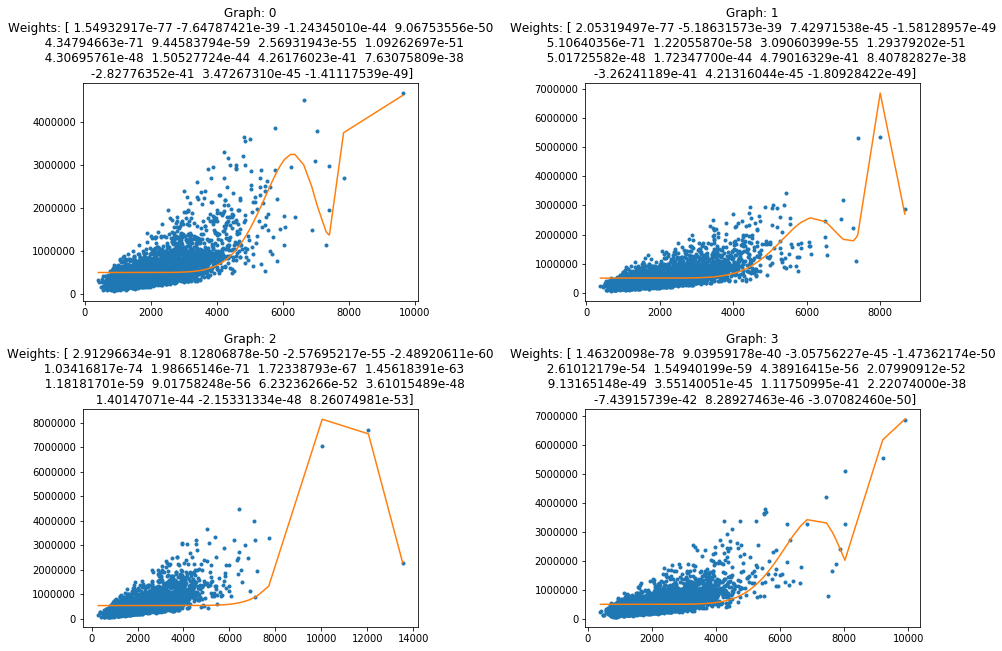

In [12]:
# make some graphs
plt.figure(figsize=(15, 10))
for i in range(len(linear_models_data)):
    # extract values from list
    model, poly_data, y_output = linear_models_data[i]
    predicted_output = model.predict(poly_data.values)
    # config figure
    plt.subplot(int(str(22)+str(i+1)), title='Graph: ' + str(i) + "\nWeights: " + str(model.coef_))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.plot(poly_data["power_1"], y_output,'.', poly_data["power_1"], predicted_output,'-')

In [13]:
# power_1's coefficient absolute values
for i in range(len(linear_models_data)):
    model = linear_models_data[i][0]
    print("Model {} power_1's coefficient absolute value: {}".format(i+1, np.absolute(model.coef_[0])))

Model 1 power_1's coefficient absolute value: 1.5493291692232421e-77
Model 2 power_1's coefficient absolute value: 2.0531949740907677e-77
Model 3 power_1's coefficient absolute value: 2.912966344098166e-91
Model 4 power_1's coefficient absolute value: 1.46320098000635e-78


The four curves should differ from one another a lot, as should the coefficients you learned.

***QUIZ QUESTION:  For the models learned in each of these training sets, what are the smallest and largest absolute values you learned for the coefficient of feature `power_1`?***

# Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e3`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty`, the code <u>should be the same</u> as the experiment above.

In [14]:
ridge_model_data = get_models_and_data([set_1, set_2, set_3, set_4], 'sqft_living', 'price', 15, ridge_l2_penalty=1e3)

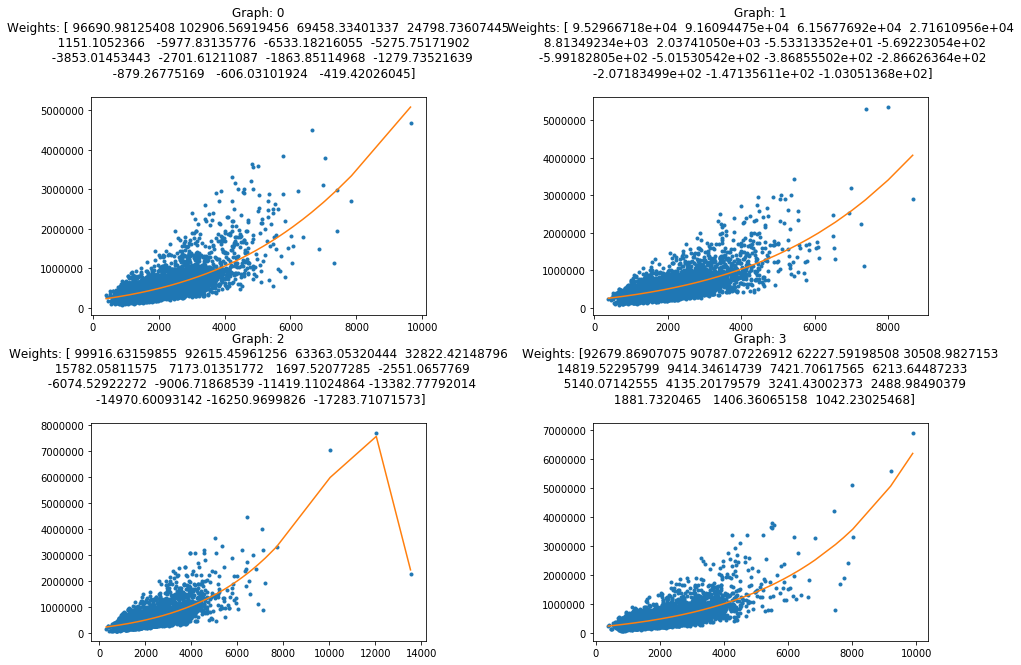

In [15]:

plt.figure(figsize=(15, 10))
for i in range(len(ridge_model_data)):
    # extract values from list
    model, poly_data, y_output = ridge_model_data[i]
    X_features = scaler.transform(poly_data.values)
    predicted_output = model.predict(X_features)
    # config figure
    plt.subplot(int(str(22)+str(i+1)), title='Graph: ' + str(i) + "\nWeights: " + str(model.coef_) + "\n")
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.plot(poly_data["power_1"], y_output,'.', poly_data["power_1"], predicted_output,'-')

In [16]:
# power_1's coefficient values
for i in range(len(ridge_model_data)):
    model = ridge_model_data[i][0]
    print("Ridge Model {} power_1's coefficient absolute value: {}".format(i+1, model.coef_[0]))

Ridge Model 1 power_1's coefficient absolute value: 96690.981254084
Ridge Model 2 power_1's coefficient absolute value: 95296.6717806163
Ridge Model 3 power_1's coefficient absolute value: 99916.63159854889
Ridge Model 4 power_1's coefficient absolute value: 92679.86907075015


These curves should vary less, now that you applied a high degree of regularization.

***QUIZ QUESTION:  For the models learned with the high level of regularization in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?*** (For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

## Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evaluate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evaluate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evaluate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. Sklearn already have a shuffling function, so we use that.

In [17]:
train_and_validation, test_data = train_test_split(full_data, train_size=0.9, test_size=0.1, random_state=1)
train_and_validation = sklearn.utils.shuffle(train_and_validation, random_state=1)

Once the data is shuffled, we divide it into equal segments. Each segment should receive `n/k` elements, where `n` is the number of observations in the training set and `k` is the number of segments. Since the segment 0 starts at index 0 and contains `n/k` elements, it ends at index `(n/k)-1`. The segment 1 starts where the segment 0 left off, at index `(n/k)`. With `n/k` elements, the segment 1 ends at index `(n*2/k)-1`. Continuing in this fashion, we deduce that the segment `i` starts at index `(n*i/k)` and ends at `(n*(i+1)/k)-1`.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [18]:
n = len(train_and_validation)
k = 10 # 10-fold cross-validation
for i in range(k):
    start = (n*i)//k
    end = (n*(i+1))//k-1
    
    print(i, (start, end))


0 (0, 1944)
1 (1945, 3889)
2 (3890, 5834)
3 (5835, 7779)
4 (7780, 9724)
5 (9725, 11669)
6 (11670, 13614)
7 (13615, 15559)
8 (15560, 17504)
9 (17505, 19450)


One of the nice things about data library in general are their ability to accept slices. To extract a continuous slice from the DataFrame, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of `train_and_validation`. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [19]:
train_and_validation[0:10] # rows 0 to 9

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
6123600285,20141107T000000,185000.0,3,1.50,1010,7755,1.0,0,0,3,6,1010,0,1953,0,98148,47.4238,-122.332,1270,8350
3323059027,20140528T000000,326000.0,3,2.75,1720,28000,1.0,0,0,4,7,1720,0,1958,0,98058,47.4375,-122.176,2000,41817
5316100920,20140725T000000,2250000.0,3,4.25,5150,7800,2.5,0,2,3,11,4170,980,1954,0,98112,47.6288,-122.282,4270,7800
4315700175,20140612T000000,440000.0,3,1.00,1210,5750,1.5,0,0,4,7,1210,0,1910,0,98136,47.5403,-122.391,1160,5000
303000445,20140523T000000,175000.0,2,1.00,1300,44431,1.0,0,0,5,6,1300,0,1958,0,98001,47.3270,-122.267,1470,14850
2130410050,20140513T000000,287000.0,3,2.25,1490,9600,1.0,0,0,4,7,1170,320,1987,0,98019,47.7378,-121.977,1590,10104
7972601885,20150430T000000,350000.0,5,1.75,1380,7620,1.0,0,0,3,7,1180,200,1955,0,98106,47.5279,-122.345,1990,7620
3362400511,20150304T000000,570000.0,3,1.75,1260,3328,1.0,0,0,5,6,700,560,1905,0,98103,47.6823,-122.349,1380,3536
7889600190,20150113T000000,229000.0,3,1.00,1590,6240,1.0,0,0,3,7,1060,530,1956,0,98146,47.4936,-122.337,1410,6240


Now let us extract individual segments with array slicing. Consider the scenario where we group the houses in the `train_and_validation` dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above.
Extract the fourth segment (segment 3) and assign it to a variable called `validation4`.

In [20]:
n = len(train_and_validation)
start = (n*3)//k
end = (n*4)//k-1
validation4 = train_and_validation[start:end]

To verify that we have the right elements extracted, run the following cell, which computes the average price of the fourth segment. When rounded to nearest whole number, the average should be $544,330.

In [21]:
print( round(validation4['price'].mean(), 0) )
# validation segment 2 = train_and_validation[3890:5834] mean: 550647.0
# validation segment 3 = train_and_validation[5835:7779] mean: 545311.0
# validation segment 4 = train_and_validation[7780:9724] mean: 544464.0

545311.0


After designating one of the k segments as the validation set, we train a model using the rest of the data. To choose the remainder, we slice (0:start) and (end+1:n) of the data and paste them together. DataFrame has `append()` method that pastes together two disjoint sets of rows originating from a common dataset. For instance, the following cell pastes together the first and last two rows of the `train_and_validation` dataframe.

In [22]:
n = len(train_and_validation)
first_two = train_and_validation[0:2]
last_two = train_and_validation[n-2:n]
print(first_two.append(last_two))

                       date      price  bedrooms  bathrooms  sqft_living  \
id                                                                         
6123600285  20141107T000000   185000.0         3       1.50         1010   
3323059027  20140528T000000   326000.0         3       2.75         1720   
6151800612  20150107T000000   162000.0         4       1.00         1460   
1088100450  20140725T000000  1720000.0         5       4.00         4590   

            sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
id                                                                             
6123600285      7755     1.0           0     0          3      6        1010   
3323059027     28000     1.0           0     0          4      7        1720   
6151800612     16638     1.0           0     0          4      6        1460   
1088100450     35046     2.0           0     0          3     10        4590   

            sqft_basement  yr_built  yr_renovated  zipcode    

Extract the remainder of the data after *excluding* fourth segment (segment 3) and assign the subset to `train4`.

In [23]:
# time to use your brain. Where do the fourth segment start and end? What do .append do?
train4 = train_and_validation[:start].append(train_and_validation[end+1:])

To verify that we have the right elements extracted, run the following cell, which computes the average price of the data with fourth segment excluded. When rounded to nearest whole number, the average should be $540,120.

In [24]:
print( round(train4['price'].mean(), 0) )

540120.0


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) name of output column (e.g. `price`) and (v) list of feature names. The function returns the average validation error using k segments as validation sets.

* For each i in [0, 1, ..., k-1]:
  * Compute starting and ending indices of segment i and call 'start' and 'end'
  * Form validation set by taking a slice (start:end+1) from the data.
  * Form training set by appending slice (end+1:n) to the end of slice (0:start).
  * Train a linear model using training set just formed, with a given l2_penalty
  * Compute validation error using validation set just formed

Also, sklearn have an built-in `mean_squared_error` function.

In [25]:
def k_fold_cross_validation(k: int, l2_penalty, data, output_name: str, features_list, degree=15):
    # implement the function.
    n = len(data)
    errors = 0
    # get polynomial of features_list
    poly_data = polynomial_dataframe(data[features_list], degree)
    for i in range(k-1):
        start = (n*i)//k
        end = (n*(i+1))//k-1
        # prepare train data
        X_train = scaler.transform(poly_data[0:start].append(poly_data[end+1:n]).values)
        y_true_train = data[0:start].append(data[end+1:n])[output_name].values
        model = Ridge(alpha=l2_penalty).fit(X_train, y_true_train)
        # prepare validation data
        X_validation =  scaler.transform(poly_data[start:end].values)
        y_true_validation = data[start:end][output_name].values
        y_pred_validation = model.predict(X_validation) # predict output
        errors += mean_squared_error(y_true_validation, y_pred_validation) # MSE 
#         errors += (np.sum(np.square((y_true_validation, y_pred_validation))) + 
#                    l2_penalty*np.sqrt(np.sum(np.square(model.coef_)))) # total cost
    return errors/n

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^0, 10^0.5, 10^1, 10^1.5, ..., 10^2] (to get this in Python, you can use this Numpy function: `np.logspace(0, 10, num=21)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use `train_and_validation` when generating polynomial features!

If you are seeing two much reds from `scipy.linalg.solve`, import `warnings` and use `warnings.filterwarnings('ignore')`. Not best practice, but useful. Once you are done, set `warnings.resetwarnings()` to turn it back to normal.

In [30]:
# Best practice vs your eyes.
mean_errors_l2 = []

k = 10
for l2_penalty in np.logspace(0, 10, num=21):
    mean_errors_l2.append([k_fold_cross_validation(k, l2_penalty, train_and_validation, 'price', 'sqft_living'), l2_penalty]) 

In [35]:
best_l2 = sorted(mean_errors_l2)[0][1]
best_l2

316.22776601683796

***QUIZ QUESTIONS:  What is the best value for the L2 penalty according to 10-fold validation?***

You may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method. Also you can use `plt.xscale('log')` for an intuitive plot. [Quitter.](https://xkcd.com/1162/)

Text(0, 0.5, 'error')

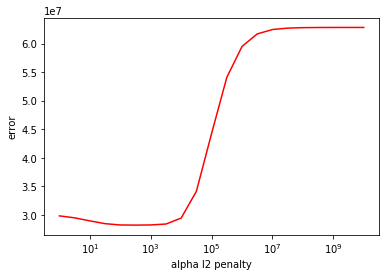

In [32]:
# Plot the l2_penalty values(maybe in log) in the x axis and the cross-validation error in the y axis.
np_mean_errors = np.array(mean_errors_l2)
plt.plot(np_mean_errors[:, 1], np_mean_errors[:, 0], color='r')
plt.xscale('log')
plt.xlabel('alpha l2 penalty')
plt.ylabel('error')

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`. This way, your final model will be trained on the entire dataset.

In [36]:
X_input_train = scaler.transform(polynomial_dataframe(train_and_validation["sqft_living"], 15))
y_true_train = train_and_validation['price']
model = Ridge(alpha=best_l2).fit(X_input_train, y_true_train)

***QUIZ QUESTION: Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty? ***

In [37]:
X_test = scaler.transform(polynomial_dataframe(test_data['sqft_living'], 15))
y_pred = model.predict(X_test)
y_test_true = test_data['price']
print(np.sum(np.square(y_test_true-y_pred)))

143188660022631.72
